In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',100)    

display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from itertools import combinations, takewhile
import collections
import pandas as pd
import numpy as np
import os

from simhash import Simhash, SimhashIndex

sns.set()

from Utils.UtilsViz import *
from Utils.UtilsGeoViz import *

print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [2]:
# fpath = os.path.join(os.getcwd(), "temp.csv")
fpath = os.path.join(os.getcwd(), "temp2.csv")
tweets_df = pd.read_csv(fpath, index_col="Unnamed: 0", nrows=2e6)
display(
    tweets_df.shape,
    tweets_df.head()
)

(2000000, 25)

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,place_country,place_country_code,place_name,place_place_type,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned,scraped_timestamp
0,8.778927e+17,RT @ArkansasBlog: Study: States with concealed carry laws experience rise in violent crime. http...,NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,1.550783e+08,Lake Man,1554.0,56574.0,95959.0,2577.0,NaN,0.0,[],False,NaN,NaN,NaN,NaN,0.0,False,17131180,Arkansas Blog,[],2.017062e+11
1,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,7.159992e+06,Annie Williams,22.0,167.0,417.0,87.0,NaN,0.0,[],False,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,[],2.017062e+11
2,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,8.271887e+17,Indivisible9IL,264.0,111.0,342.0,231.0,NaN,0.0,[],False,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,[],2.017062e+11
3,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,8.313191e+17,Indivisible Illinois,1027.0,1626.0,982.0,267.0,NaN,0.0,[],False,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,[],2.017062e+11
4,8.778927e+17,Day 1 of Chicago Summit: Gregory Touhill delivers keynote on Cybersecurity=Risk Management #ISMG...,NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,3.998460e+07,ISMG Network News,2395.0,119.0,12833.0,960.0,NaN,0.0,"[Row(indices=[91, 103], text='ISMGSummits'), Row(indices=[104, 112], text='infosec')]",False,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,"['ISMGSummits', 'infosec']",2.017062e+11


In [9]:
from ast import literal_eval

def le(row):
    if (row is np.NaN) or (row is np.nan):
        return []
    elif row is None:
        return []
    elif type(row) == type(1.0):
        return []
    else:
        try:
            return literal_eval(row)
        except Exception as e:
#             print("Exception caught!", e)
#             print(row, type(row))
            return []

tweets_df['hashtags_cleaned']=tweets_df['hashtags_cleaned'].apply(le)


In [10]:
tweets_df["text"].fillna(value="", inplace=True)
tweets_df["text_len"] = tweets_df["text"].apply(len)

# Q1 - Identify tweets related to UChicago and 3-4 universities of your choice

In [11]:
uc_favored_tags = ["uchicago", "uchearing", "universityofchicago", "pritzkerschoolofmedicine",
                   "uofc", "maroonmade", "chicagobooth"]
nw_favored_tags = ["northwestern"]
upenn_favored_tags = ["upenn", "penn", "uofpenn", "universityofpennsylvania", "pennlaw", "upennhearing"]
uic_favored_tags = ["UIC", "UICProud"]
mit_favored_tags = ["MIT"]
stanford_favored_tags = ["stanford"]

def is_stanford_tweet(row):
    if row is np.NaN:
        return False
    for ftag in stanford_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_upenn_tweet(row):
    if row is np.NaN:
        return False
    for ftag in upenn_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_nw_tweet(row):
    if row is np.NaN:
        return False
    for ftag in nw_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_uc_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uc_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_uic_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uic_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_mit_tweet(row):
    if row is np.NaN:
        return False
    for ftag in mit_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

tweets_df["mit_tweet"] = tweets_df["hashtags_cleaned"].apply(is_mit_tweet)
tweets_df["stanford_tweet"] = tweets_df["hashtags_cleaned"].apply(is_stanford_tweet)
tweets_df["nw_tweet"] = tweets_df["hashtags_cleaned"].apply(is_nw_tweet)
tweets_df["upenn_tweet"] = tweets_df["hashtags_cleaned"].apply(is_upenn_tweet)
tweets_df["uc_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uc_tweet)
tweets_df["uic_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uic_tweet)

cols = ["uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet"]

def is_uni_tweet(row):
    for col in cols:
        if row[col]:
            return True
    else:
        return False

tweets_df["uni_tweet"] = tweets_df[cols].apply(is_uni_tweet, axis=1)

def is_uni_tweet2(row):
    for col in cols:
        if row[col]:
            return col[0:-6]
    else:
        return ""

tweets_df["uni_tweet_name"] = tweets_df[cols].apply(is_uni_tweet2, axis=1)

Make a subset data set that only picks tweets related to universities we're analysing.

In [12]:
uni_df = tweets_df[(tweets_df["uni_tweet"]==True)]

Let's just quickly make a Time dimension for ease of use later on.

In [13]:
uni_df["created_at"] = pd.to_datetime(uni_df['created_at'])

In [14]:
uni_df['created_month'] = uni_df['created_at'].map(lambda x: x.month)
uni_df['created_year'] = uni_df['created_at'].map(lambda x: x.year)
uni_df['created_date'] = uni_df['created_at'].map(lambda x: x.day)
uni_df['created_dayofweek'] = uni_df['created_at'].map(lambda x: x.weekday_name)

In [15]:
uni_df.shape

(4643, 38)

# Q2 - Identify the most prolific / influential Twitterers
1. By message volume
1. By message retweet
1. How much are they tweeting about the Universities vs. other topics? 

Can we identify Retweets?

In [17]:
uni_df["retweeted_status_user_id_str"].count()

1894

## Most active users

In [117]:
user_grp = uni_df[["id_str", "user_id_str", "user_name"]].groupby(by=["user_name"], as_index=False).count()
user_grp.reset_index(drop=True, inplace=True)
user_grp.sort_values(by="id_str", inplace=True, ascending=False)
user_grp.head()

,user_name,id_str,user_id_str
1280,Laura Fornaro,213,213
474,Climber.com EDU Jobs,124,124
2432,Vi Rai⚡️ (ϑ ℛai),71,71
1655,Northwestern Spyder,68,68
2102,Stanford Bee,46,46


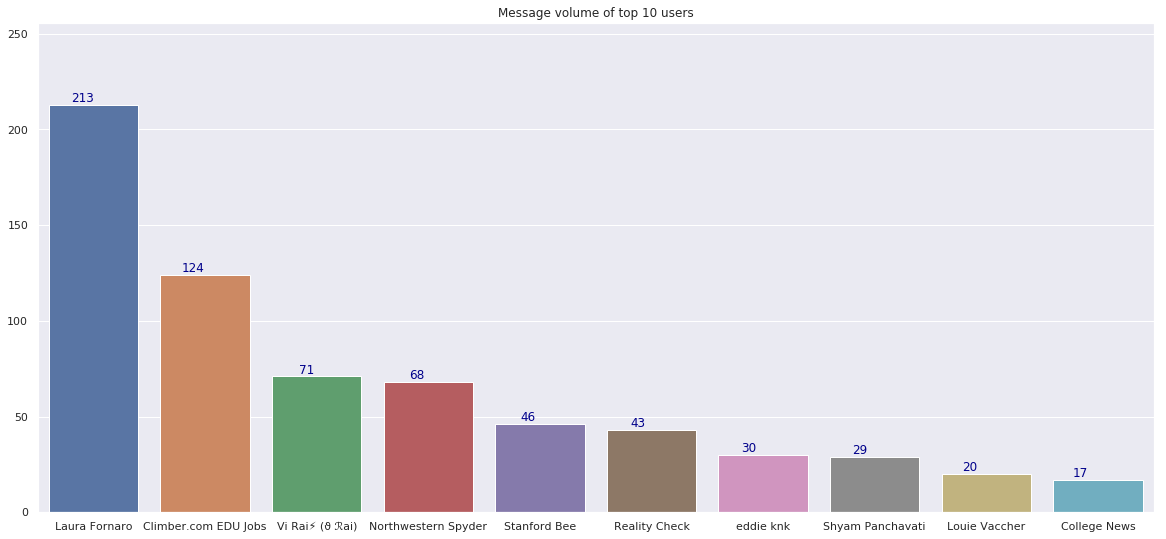

In [123]:
user_subset = user_grp.iloc[:10,:]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(20,9))
plot_bar(data=user_subset, x="user_name", y="id_str", ax=ax, title="Message volume of top 10 users", highlight_max_min=False)

### Message Retweet

###### <font color=red> NOTE : CHANGE DATAFRAME TO uni_df WHEN RUNNING ONLINE </font>

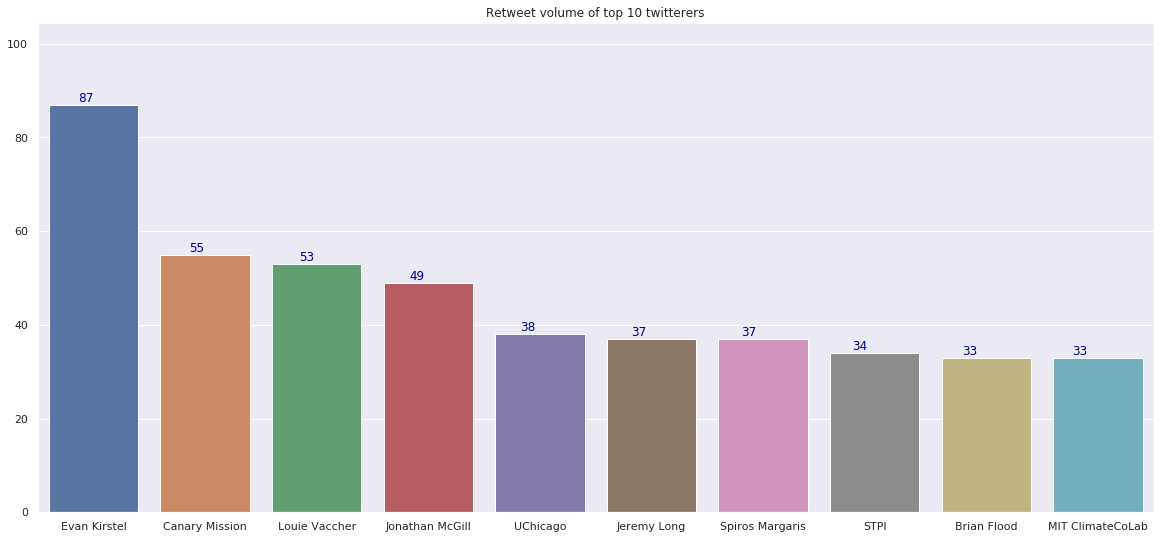

In [133]:
user_rt_grp = uni_df[["id_str", "retweeted_status_user_name"]].groupby(by=["retweeted_status_user_name"], as_index=False).count()
user_rt_grp.reset_index(drop=True, inplace=True)
user_rt_grp.sort_values(by="id_str", inplace=True, ascending=False)

user_subset = user_rt_grp.iloc[:10,:]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(20,9))
plot_bar(data=user_subset, x="retweeted_status_user_name", y="id_str", ax=ax, title="Retweet volume of top 10 twitterers", highlight_max_min=False)

### How much are they tweeting about the Universities vs. other topics?

In [31]:
prolific_users = user_subset["user_name"].unique()

In [32]:
cols = ["id_str", "user_id_str", "text", "user_name", "hashtags_cleaned", "uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet", "uni_tweet"]
uvnu_df = tweets_df[tweets_df["user_name"].isin(prolific_users)][cols]
def tmpfun(row):
    if row:
        return 1
    else:
        return 0
uvnu_df["uni_tweet"] = uvnu_df["uni_tweet"].apply(tmpfun)
uvnu_df.shape

(903, 12)

In [33]:
tmp_df = uvnu_df[["user_name", "uni_tweet"]].groupby(by="user_name", as_index=False).agg(["sum", "count"])
tmp_df.columns = ["uni_tweets", "total_tweets"]
tmp_df.reset_index(drop=False, inplace=True)
tmp_df["ratio"] = tmp_df["uni_tweets"] / tmp_df["total_tweets"]
tmp_df

,user_name,uni_tweets,total_tweets,ratio
0,Climber.com EDU Jobs,124,258,0.480620
1,Laura Fornaro,213,213,1.000000
2,Northwestern Spyder,68,68,1.000000
3,Reality Check,43,99,0.434343
4,Shyam Panchavati,29,37,0.783784
5,Stanford Bee,46,46,1.000000
6,Vi Rai⚡️ (ϑ ℛai),71,152,0.467105
7,eddie knk,30,30,1.000000


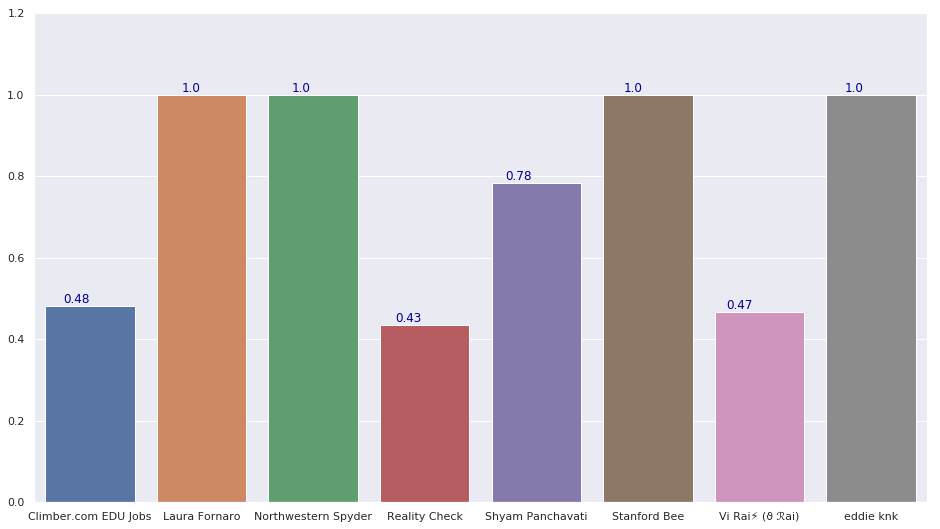

In [34]:
f, ax = plt.subplots(1,1,figsize=(16,9))
plot_bar(data=tmp_df, x="user_name", y="ratio", ax=ax, highlight_max_min=False)

## Where are these Twitterers located?
-  For UChicago
-  For other universities
-  Do you see any relationship between university locations and Twitterers’ locations?
-  Visualize the relationships

In [53]:
places_df = uni_df[["id_str", "user_name", "place_country", "place_country_code", "place_name", "place_place_type", "uni_tweet_name"]].dropna()
places_df

,id_str,user_name,place_country,place_country_code,place_name,place_place_type,uni_tweet_name
3239,8.778978e+17,Miranda Weinberg,United States,US,Philadelphia,city,upenn
3470,8.778981e+17,Miranda Weinberg,United States,US,Philadelphia,city,upenn
3904,8.778987e+17,UChicago SpecColl,United States,US,Chicago,city,uc
4885,8.779002e+17,Miranda Weinberg,United States,US,Philadelphia,city,upenn
5012,8.779004e+17,Miranda Weinberg,United States,US,Philadelphia,city,upenn
6705,8.779031e+17,Matt DeBary,United States,US,Marietta,city,stanford
9210,8.779066e+17,Miranda Weinberg,United States,US,Washington,city,upenn
20807,8.779253e+17,Miranda Weinberg,United States,US,Washington,city,upenn
20813,8.779253e+17,ClemsonResearch,United States,US,Clemson,city,mit
22081,8.779272e+17,Rivals.com,United States,US,Plano,city,stanford


In [100]:
def get_top5_places(dfs):
    return dfs.value_counts().iloc[:5].index

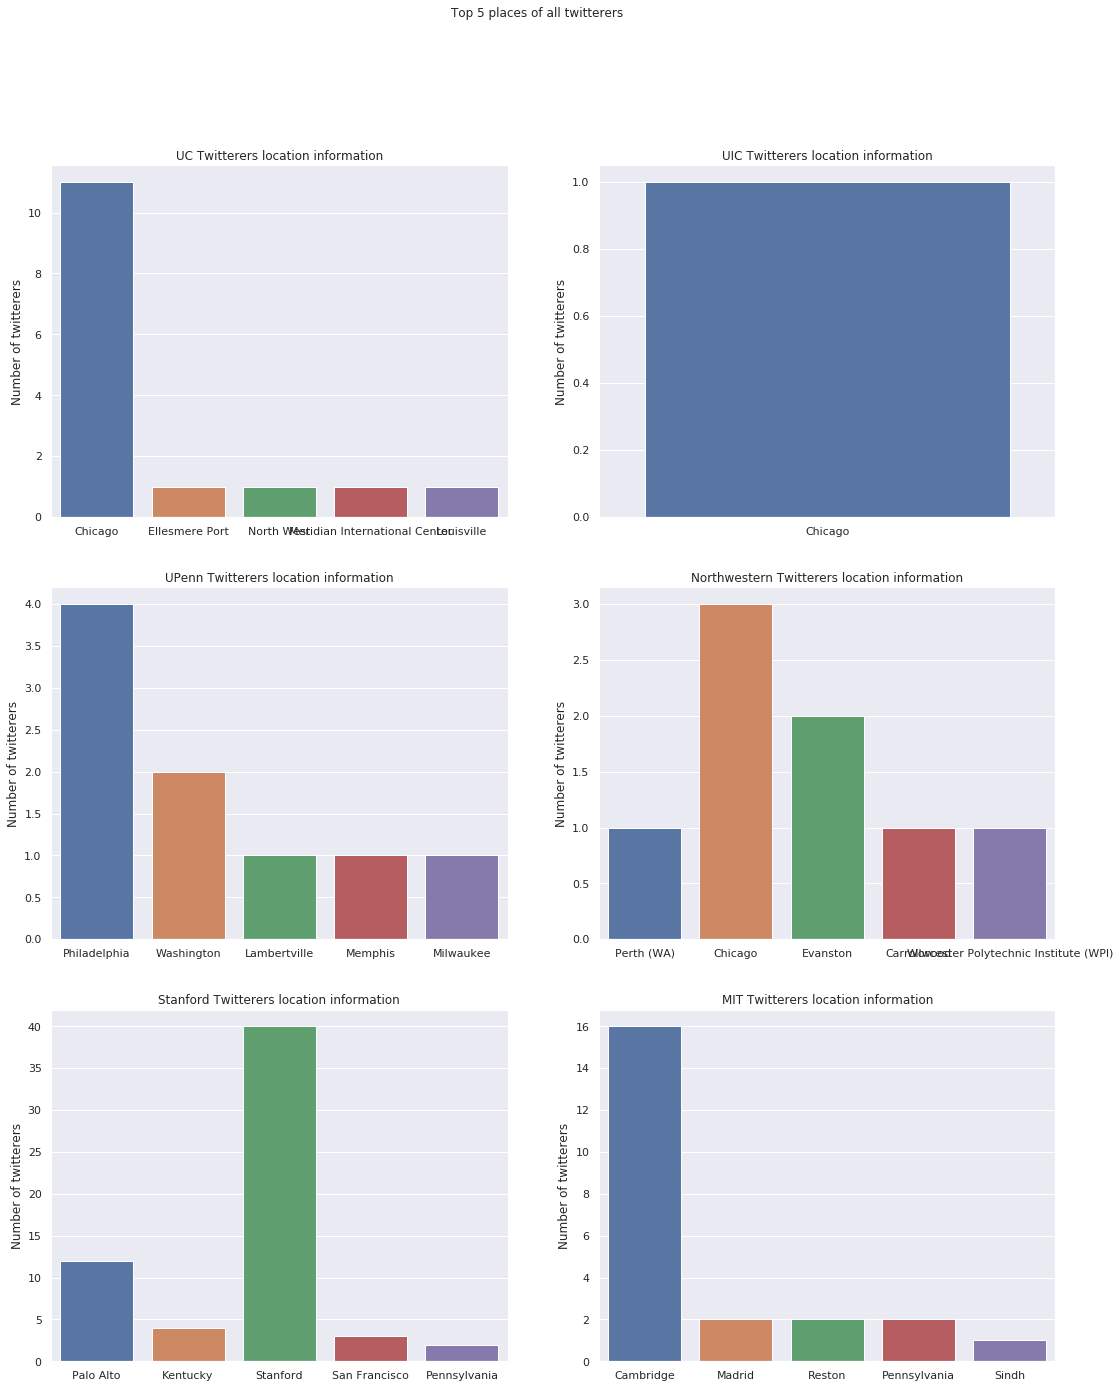

In [99]:
uc_places_df = places_df[places_df["uni_tweet_name"]=="uc"]
upenn_places_df = places_df[places_df["uni_tweet_name"]=="upenn"]
uic_places_df = places_df[places_df["uni_tweet_name"]=="uic"]
nw_places_df = places_df[places_df["uni_tweet_name"]=="nw"]
stanford_places_df = places_df[places_df["uni_tweet_name"]=="stanford"]
mit_places_df = places_df[places_df["uni_tweet_name"]=="mit"]

# Just use the top 5 places
uc_places_df = uc_places_df[uc_places_df["place_name"].isin(get_top5_places(uc_places_df["place_name"]))]
upenn_places_df = upenn_places_df[upenn_places_df["place_name"].isin(get_top5_places(upenn_places_df["place_name"]))]
uic_places_df = uic_places_df[uic_places_df["place_name"].isin(get_top5_places(uic_places_df["place_name"]))]
nw_places_df = nw_places_df[nw_places_df["place_name"].isin(get_top5_places(nw_places_df["place_name"]))]
stanford_places_df = stanford_places_df[stanford_places_df["place_name"].isin(get_top5_places(stanford_places_df["place_name"]))]
mit_places_df = mit_places_df[mit_places_df["place_name"].isin(get_top5_places(mit_places_df["place_name"]))]

f, ax = plt.subplots(3, 2,figsize=(18, 22))

g = sns.countplot(x="place_name", data=uc_places_df, ax=ax[0][0])
t = ax[0][0].set(title="UC Twitterers location information", ylabel="Number of twitterers", xlabel="")
t = g.set_xticklabels(g.get_xticklabels(), rotation=0)

g = sns.countplot(x="place_name", data=uic_places_df, ax=ax[0][1])
t = ax[0][1].set(title="UIC Twitterers location information", ylabel="Number of twitterers", xlabel="")

g = sns.countplot(x="place_name", data=upenn_places_df, ax=ax[1][0])
t = ax[1][0].set(title="UPenn Twitterers location information", ylabel="Number of twitterers", xlabel="")

g = sns.countplot(x="place_name", data=nw_places_df, ax=ax[1][1])
t = ax[1][1].set(title="Northwestern Twitterers location information", ylabel="Number of twitterers", xlabel="")

g = sns.countplot(x="place_name", data=stanford_places_df, ax=ax[2][0])
t = ax[2][0].set(title="Stanford Twitterers location information", ylabel="Number of twitterers", xlabel="")

g = sns.countplot(x="place_name", data=mit_places_df, ax=ax[2][1])
t = ax[2][1].set(title="MIT Twitterers location information", ylabel="Number of twitterers", xlabel="")

st = plt.suptitle("Top 5 places of all twitterers")


## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
Visualize the trends

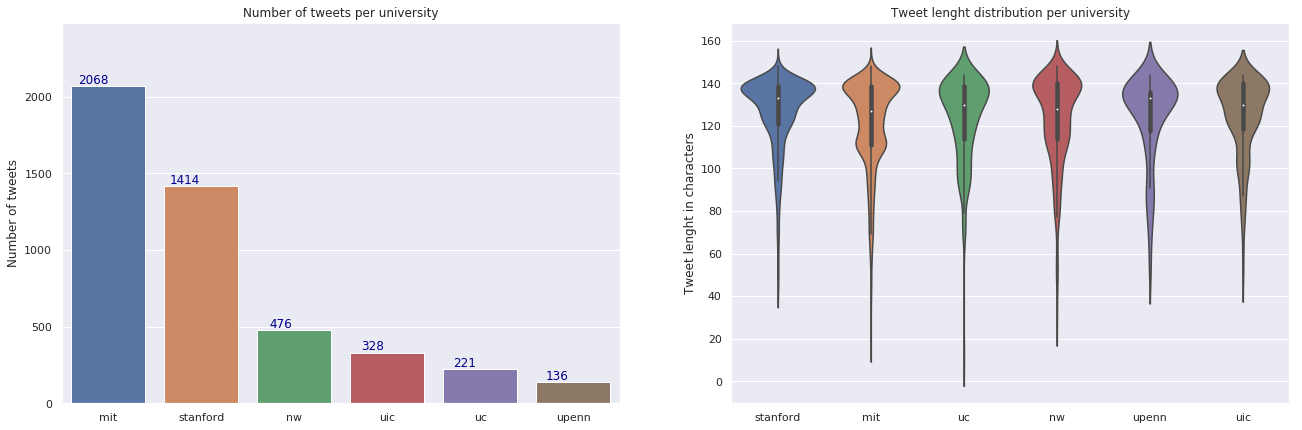

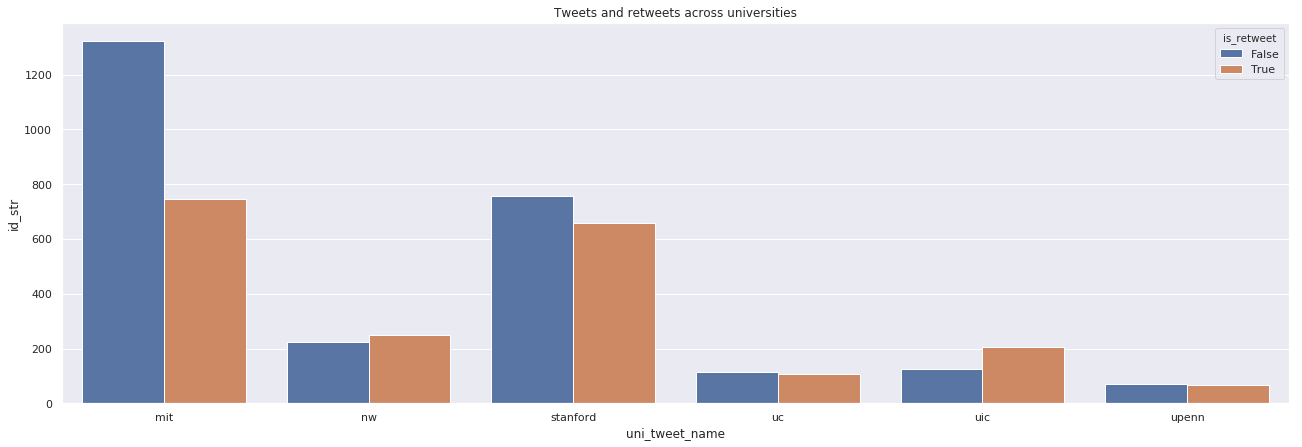

In [101]:
f, ax = plt.subplots(1,2,figsize=(22,7))

uni_counts = uni_df["uni_tweet_name"].value_counts().to_frame()
uni_counts.reset_index(drop=False, inplace=True)
uni_counts.columns = ["university", "num_tweets"]
plot_bar(x="university", y="num_tweets", data=uni_counts, ax=ax[0], highlight_max_min=False,
        title="Number of tweets per university", ylabel="Number of tweets")

sns.violinplot(data=uni_df, x="uni_tweet_name", y="text_len", ax=ax[1] )
t = ax[1].set(title="Tweet lenght distribution per university", ylabel="Tweet lenght in characters", xlabel="")

rt_uni_df = uni_df[["id_str", "retweeted_status_user_id_str", "uni_tweet_name"]]
rt_uni_df["is_retweet"] = rt_uni_df["retweeted_status_user_id_str"].apply(lambda x: True if x is not np.NaN else False)
rt_uni_grp = rt_uni_df.groupby(["uni_tweet_name", "is_retweet"], as_index=False).count()

f, ax = plt.subplots(1, 1, figsize=(22, 7))
g = sns.barplot(x="uni_tweet_name", y="id_str", hue="is_retweet", data=rt_uni_grp, ax=ax)
t = g.set(title="Tweets and retweets across universities")

## What are the timelines of these tweets? Do you see significant peaks and valleys?
Do you see data collection gaps?

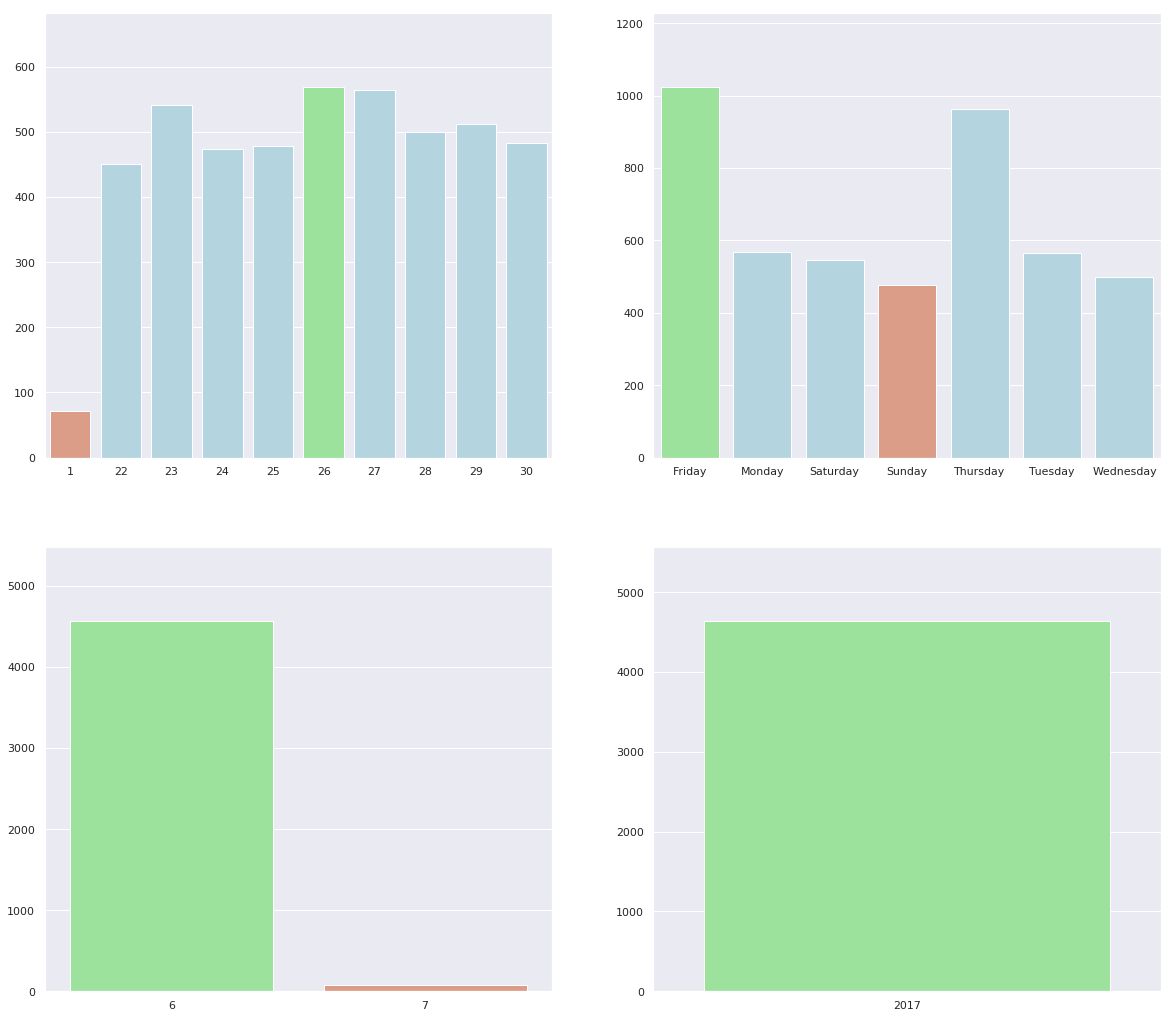

In [102]:
uni_df_date_grp = uni_df[["id_str", "created_date"]].groupby(by="created_date", as_index=False).count()
uni_df_dayofweek_grp = uni_df[["id_str", "created_dayofweek"]].groupby(by="created_dayofweek", as_index=False).count()
uni_df_month_grp = uni_df[["id_str", "created_month"]].groupby(by="created_month", as_index=False).count()
uni_df_year_grp = uni_df[["id_str", "created_year"]].groupby(by="created_year", as_index=False).count()

f, ax = plt.subplots(2,2,figsize=(20,18))
plot_bar(data=uni_df_date_grp, x="created_date", y="id_str", ax=ax[0][0], annot=False)
plot_bar(data=uni_df_dayofweek_grp, x="created_dayofweek", y="id_str", ax=ax[0][1], annot=False)
plot_bar(data=uni_df_month_grp, x="created_month", y="id_str", ax=ax[1][0], annot=False)
plot_bar(data=uni_df_year_grp, x="created_year", y="id_str", ax=ax[1][1], annot=False)

## How unique are the messages for each of these universities?
-  Are they mostly unique? Or mostly people are just copy-pasting the same text?
-  You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
-  Visualize message duplication (for each university – not between the universities)

In [103]:
tweets_df["text"].head()

0    RT @ArkansasBlog: Study: States with concealed carry laws experience rise in violent crime. http...
1    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
2    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
3    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
4    Day 1 of Chicago Summit: Gregory Touhill delivers keynote on Cybersecurity=Risk Management #ISMG...
Name: text, dtype: object

We will need to remove all the Re-tweets to ensure we aren't inordinately biased towards some tweets.

In [104]:
rows_to_drop = uni_df[~uni_df["retweeted_status_user_id_str"].isna()].index
# Drop all the rows with retweets
unique_uni_tweets_df = uni_df.drop(rows_to_drop, axis=0)

In [105]:
uc_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uc_tweet"]==True]["text"]
uic_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uic_tweet"]==True]["text"]
upenn_tweets = unique_uni_tweets_df[unique_uni_tweets_df["upenn_tweet"]==True]["text"]
nw_tweets = unique_uni_tweets_df[unique_uni_tweets_df["nw_tweet"]==True]["text"]
stanford_tweets = unique_uni_tweets_df[unique_uni_tweets_df["stanford_tweet"]==True]["text"]
mit_tweets = unique_uni_tweets_df[unique_uni_tweets_df["mit_tweet"]==True]["text"]

Some helper functions

In [106]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

def get_ratios(df):
    data = df.to_dict()
    objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
    index = SimhashIndex(objs, k=3)
    list_all = []
    for i in range(0,len(data)):
        s1 = list(data.values())[i]
        s2 = Simhash(get_features(s1))
        list_all.append(len(index.get_near_dups(s2)))
    a = [0 if i == 1 else 1 for i in list_all]
    duplicate = sum(a)
    unique = len(a)-sum(a)
    return duplicate, unique

In [107]:
uc_dup, uc_unique = get_ratios(uc_tweets)
uic_dup, uic_unique = get_ratios(uic_tweets)
upenn_dup, upenn_unique = get_ratios(upenn_tweets)
nw_dup, nw_unique = get_ratios(nw_tweets)
stanford_dup, stanford_unique = get_ratios(stanford_tweets)
mit_dup, mit_unique = get_ratios(mit_tweets)

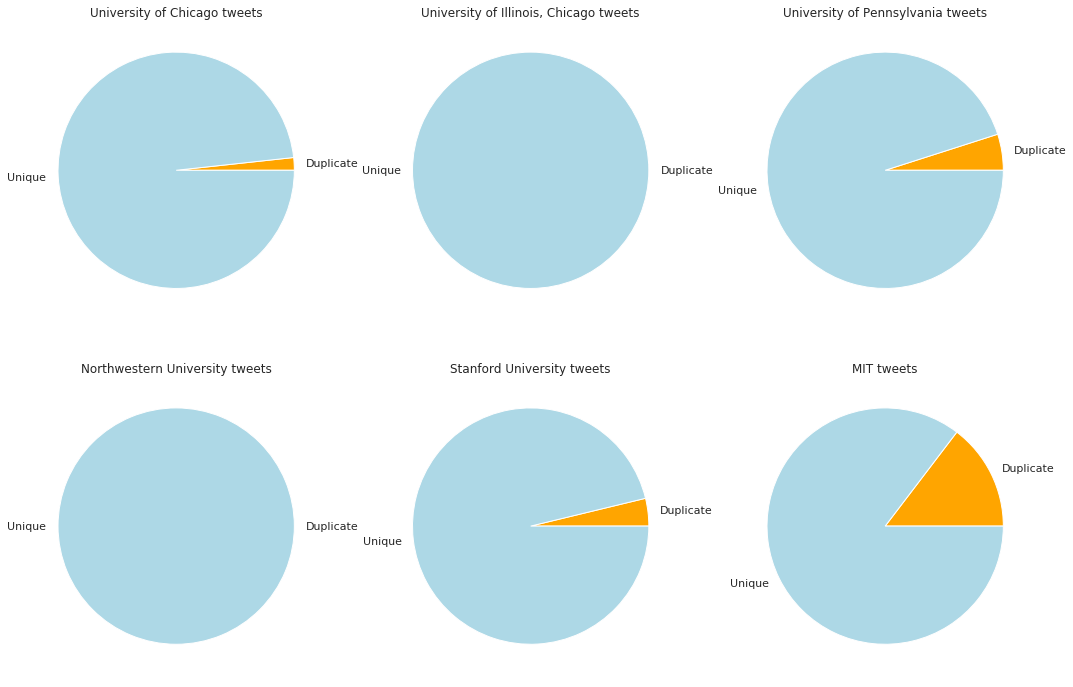

In [108]:
def plot_pie(values, labels, colors, ax):
    ax.pie(x=values, labels=labels, colors=colors)

labels = ['Duplicate', 'Unique']
colors = ['orange','lightblue']
f, ax = plt.subplots(2, 3, figsize=(18, 12))
plot_pie(values=[uc_dup, uc_unique], labels=labels, colors=colors, ax=ax[0][0])
ax[0][0].set(title="University of Chicago tweets")

plot_pie(values=[uic_dup, uic_unique], labels=labels, colors=colors, ax=ax[0][1])
ax[0][1].set(title="University of Illinois, Chicago tweets")

plot_pie(values=[upenn_dup, upenn_unique], labels=labels, colors=colors, ax=ax[0][2])
ax[0][2].set(title="University of Pennsylvania tweets")

plot_pie(values=[nw_dup, nw_unique], labels=labels, colors=colors, ax=ax[1][0])
ax[1][0].set(title="Northwestern University tweets")

plot_pie(values=[stanford_dup, stanford_unique], labels=labels, colors=colors, ax=ax[1][1])
ax[1][1].set(title="Stanford University tweets")

plot_pie(values=[mit_dup, mit_unique], labels=labels, colors=colors, ax=ax[1][2])
t = ax[1][2].set(title="MIT tweets")

